# Example of a discovery significance computation.

In [1]:
from statnight import Hypothesis, Observable, Model, Constant, Variable
from statnight.calculators import AsymptoticCalculator
from statnight.utils.pdf import Gaussian, gaussian, exponential
from scipy.stats import expon
from statnight.utils.stats import integrate1d
import numpy as np
import matplotlib.pyplot as plt
import iminuit
import math

## Signal + background fit:

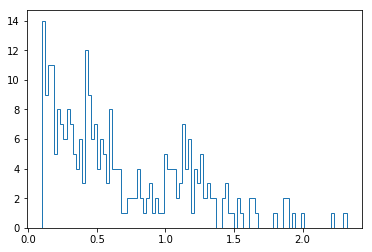

In [2]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 40)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

plt.hist(data, bins=100, histtype='step');

In [3]:
def exp_normalized(x, tau):
    ret = exponential(x, tau)
    norm = exponential.integrate(bounds, 100, tau)
    return ret/norm

def gauss_normalized(x, mu, sigma):  
    ret = gaussian(x, mu, sigma)
    norm = gaussian.integrate(bounds, 100, mu, sigma)
    return ret/ norm

def exp_extended(x, tau, Nbkg):  
    ret = exp_normalized(x, tau)
    return ret * Nbkg

def gauss_extended(x, mu, sigma, Nsig):  
    ret = gauss_normalized(x, mu, sigma)
    return ret * Nsig

def totpdf(x, mu, sigma, Nsig, tau, Nbkg):
    ret  = gauss_extended(x, mu, sigma, Nsig)
    ret += exp_extended(x, tau, Nbkg)
    return ret

#### Model definition:

Construct a model from a given probability density function (pdf) and then assign which parameters of the pdf are observables or variables/constants and initialize them.

Observable and Variable require a name and a range. Optional arguments can be given to Variable such as an initial value and initial step for minuit, and constraint wich is a function.
Constant only require a name and a value.

In [4]:
model_sb = Model(totpdf)

model_sb.add_obs(Observable("x", range = bounds))

mean  = Constant("mu",  value=1.2)
sigma = Constant("sigma", value= 0.1)
Nsig  = Variable("Nsig",  range=(-10,len((data))),   initvalue= 0.0,       initstep=1.0)
tau   = Variable("tau",   range=(0.1, 5.0), initvalue=0.5, initstep=0.05)
Nbkg  = Variable("Nbkg",  range=(0,len((data))*1.1), initvalue= len(data), initstep=1.0)

model_sb.add_vars([mean, sigma, Nsig, tau, Nbkg])

model_sb.add_ext_pars(["Nsig","Nbkg"])

In [5]:
# fit signal + background on data

lh_sb = model_sb.nll_function(data)

params = {}
for v in model_sb.variables:
    params.update(v.tominuit())

minuit_sb = iminuit.Minuit(lh_sb, pedantic=True, errordef=0.5, **params)

In [6]:
minuit_sb.migrad();

FCN = -1219.4499838709767 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 2.7197933028317964e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mu,1.2,1,,,,,Yes
1,sigma,0.1,1,,,,,Yes
2,Nsig,34.9159,8.22169,,,-10,286,No
3,tau,1.94401,0.142031,,,0.1,5,No
4,Nbkg,251.03,16.7949,,,0,314.6,No


In [7]:
def plotfitresult(pdf, bounds, nbins, *args):
    x = np.linspace(bounds[0], bounds[1], nbins)
    bin_centers = x[:-1] + np.diff(x)/2.
    y = np.zeros(bin_centers.shape)
    
    for i in range(nbins-1):
        y[i] = integrate1d(pdf, (x[i],x[i+1]), 100, *args)
        
    plt.plot(bin_centers, y, "-r")      

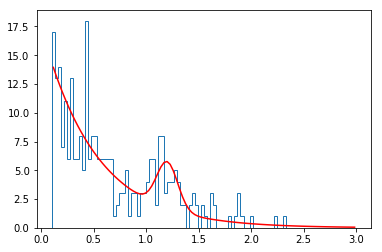

In [8]:
nbins = 100
fit_result = minuit_sb.values.values()
plt.hist(data, bins=nbins, histtype='step', range=bounds);
plotfitresult(totpdf, bounds, nbins, *fit_result)

## Discovery significance.

In [9]:
null_hypothesis = model_sb.create_hypothesis({"Nsig":0})
null_hypothesis.summary()

Observables: ['x']
Paramaters of interest: {'Nsig': 0}
Nuisance parameters: ['mu', 'sigma', 'tau', 'Nbkg']
Extended parameters: ['Nsig', 'Nbkg']



In [10]:
alt_hypothesis = model_sb.create_hypothesis({"Nsig":minuit_sb.values["Nsig"]})
alt_hypothesis.summary()

Observables: ['x']
Paramaters of interest: {'Nsig': 34.91594745781645}
Nuisance parameters: ['mu', 'sigma', 'tau', 'Nbkg']
Extended parameters: ['Nsig', 'Nbkg']



In [11]:
calc = AsymptoticCalculator(null_hypothesis, alt_hypothesis, data)
calc.qtilde = False
calc.CLs = True
calc.onesideddiscovery = True

In [12]:
result = calc.result()

Get fit best values for nuisance parameters for alternative hypothesis!


FCN = -1219.4499951381638 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = 1.1673561028728626e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mu,1.2,1,,,,,Yes
1,sigma,0.1,1,,,,,Yes
2,Nsig,34.9159,1,,,-10,286,Yes
3,tau,1.94346,0.136556,,,0.1,5,No
4,Nbkg,251.08,16.3275,,,0,314.6,No


p_value for the Null hypothesis = 7.237582233532436e-08
Significance = 5.259113352985305
CL_b = 7.237582233532436e-08
CL_s+b = 0.5347970597222849
CL_s = 7389167.300158844


In [13]:
result

{'pnull': 7.237582233532436e-08,
 'significance': 5.259113352985305,
 'clb': 7.237582233532436e-08,
 'clsb': 0.5347970597222849,
 'cls': 7389167.300158844}